<a href="https://colab.research.google.com/github/maxinelanier/Homelessness/blob/main/Maxine_Lanier_addedsubset_Homelessness_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This notebook will create models to analyse the relationship between local housing market factors and homelessness rates, alongside models already created by the U.S. Department of Housing and Urban Development (HUD), with the goal of understanding which factors contribute the most to homelessness.

## Import libraries

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

from sklearn.linear_model import LinearRegression

from mpl_toolkits.mplot3d import Axes3D

import statsmodels.formula.api as smf
from mpl_toolkits import mplot3d
from matplotlib import cm

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn import linear_model, tree
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# Train-test splits and cross validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import RobustScaler

import plotly.offline as pyo
import plotly.graph_objs as go

from itertools import combinations
from math import comb

from os import name

from scipy.stats import uniform, randint
import xgboost as xgb

# Model metrics and analysis
from sklearn.metrics import  mean_squared_error, mean_absolute_error

# plot tree model
import graphviz

## Load clean data

##### $\rightarrow$ Load the clean data set from Github. 

In [62]:
df = pd.read_csv('https://raw.githubusercontent.com/maxinelanier/Homelessness/main/clean_homelessness_data%20(3).csv')

##### $\rightarrow$ Review the contents of the data set.

In [63]:
df.head()

,year,coc_number,rural,suburban,city_or_urban,total_homeless,total_sheltered,total_unsheltered,total_population,house_price_index_2009,...,rate_homeless,rate_sheltered,rate_unsheltered,percent_black,percent_latino_hispanic,percent_asian,percent_pacific_islander,percent_population_0_19,percent_population_65_plus,percent_female_population
0,2017,AK-500,0,0,1,1128.0,973.0,155.0,297376,11.743647,...,3.793178e-08,3.271952e-08,5.212257e-09,0.053811,0.089967,0.093952,0.024387,0.269161,0.099140,0.489629
1,2017,AK-501,1,0,0,717.0,578.0,139.0,444146,9.042710,...,1.614334e-08,1.301374e-08,3.129602e-09,0.019530,0.055727,0.040104,0.004593,0.278562,0.109905,0.467752
2,2017,AL-500,0,1,0,1092.0,875.0,217.0,958302,-0.852477,...,1.139516e-08,9.130733e-09,2.264422e-09,0.331147,0.040843,0.016632,0.000311,0.256410,0.149058,0.521677
3,2017,AL-501,0,0,1,606.0,341.0,265.0,622361,-8.507004,...,9.737114e-09,5.479135e-09,4.257979e-09,0.266807,0.033816,0.016889,0.000382,0.254735,0.167126,0.519669
4,2017,AL-502,1,0,0,155.0,133.0,22.0,265264,0.751167,...,5.843235e-09,5.013873e-09,8.293624e-10,0.090348,0.042056,0.004901,0.000471,0.236545,0.190708,0.513937


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 56 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   year                                        374 non-null    int64  
 1   coc_number                                  374 non-null    object 
 2   rural                                       374 non-null    int64  
 3   suburban                                    374 non-null    int64  
 4   city_or_urban                               374 non-null    int64  
 5   total_homeless                              374 non-null    float64
 6   total_sheltered                             374 non-null    float64
 7   total_unsheltered                           374 non-null    float64
 8   total_population                            374 non-null    int64  
 9   house_price_index_2009                      374 non-null    float64
 10  log_median_ren

## State your questions

How are housing market factors related to homelessness? More specifically:
- How does the density of an area (rural vs suburban vs major city) affect the homelessness rate?
- What demographic groups experience the effects of homelessness most significantly?
- How does the population of an area contribute to homelessness rates, and is this significantly different from the area density?

## Analysis

In [65]:
removed_var = ['total_sheltered', 'total_unsheltered', 'total_black', 'total_latino_hispanic', 'total_asian', 'total_pacific_islander', 'total_population_0_19', 'total_population_65_plus', 'total_female_population', 'year', 'rate_unsheltered', 'rate_sheltered']

In [66]:
df = df.drop(columns = removed_var)

In [67]:
X = df[df.columns.difference(['coc_number', 'total_homeless', 'rate_homeless', 'total_population'])]
Y = df['rate_homeless']

In [68]:
X.head()

,HUD_unit_occupancy_rate,average_Jan_temperature,average_summer_temperature,city_or_urban,city_or_urban.1,gini_coefficient_2016,high_housing_density,house_price_index_2009,log_median_rent,medicare_reimbursements_per_enrollee,...,share_no_bachelors,share_overcrowded_units_2016,share_renters_2016,share_under_18_with_single_parent,share_veteran_status,suburban,suburban.1,total_Jan_precipitation,total_annual_precipitation,utility_costs
0,99.000000,13.800000,60.799999,1,1,42.010002,0,11.743647,2.438863,8.751520,...,65.634148,4.117406,39.727921,23.379078,14.535126,0,0,1.710000,16.500000,8.500000
1,99.000000,13.800000,60.799999,0,0,40.675701,0,9.042710,2.249699,9.972870,...,75.560379,9.294898,33.922234,19.786558,14.142518,0,0,1.710000,16.500000,14.607715
2,95.083710,50.995346,80.874313,0,0,47.633533,0,-0.852477,1.862248,9.318163,...,65.983711,1.235925,31.769621,32.077599,9.149558,1,1,6.669876,38.593376,19.492331
3,87.000801,57.893360,81.939949,1,1,46.713249,0,-8.507004,1.858394,8.709522,...,74.543457,1.712736,32.109203,33.668129,11.647923,0,0,12.296666,58.519012,18.899839
4,95.178665,48.382103,79.429985,0,0,45.165546,0,0.751167,1.362010,8.967195,...,82.332657,1.539988,27.708206,27.959316,9.135015,0,0,5.462999,44.778618,18.803186


In [69]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = .15, random_state = 24)

<Axes: >

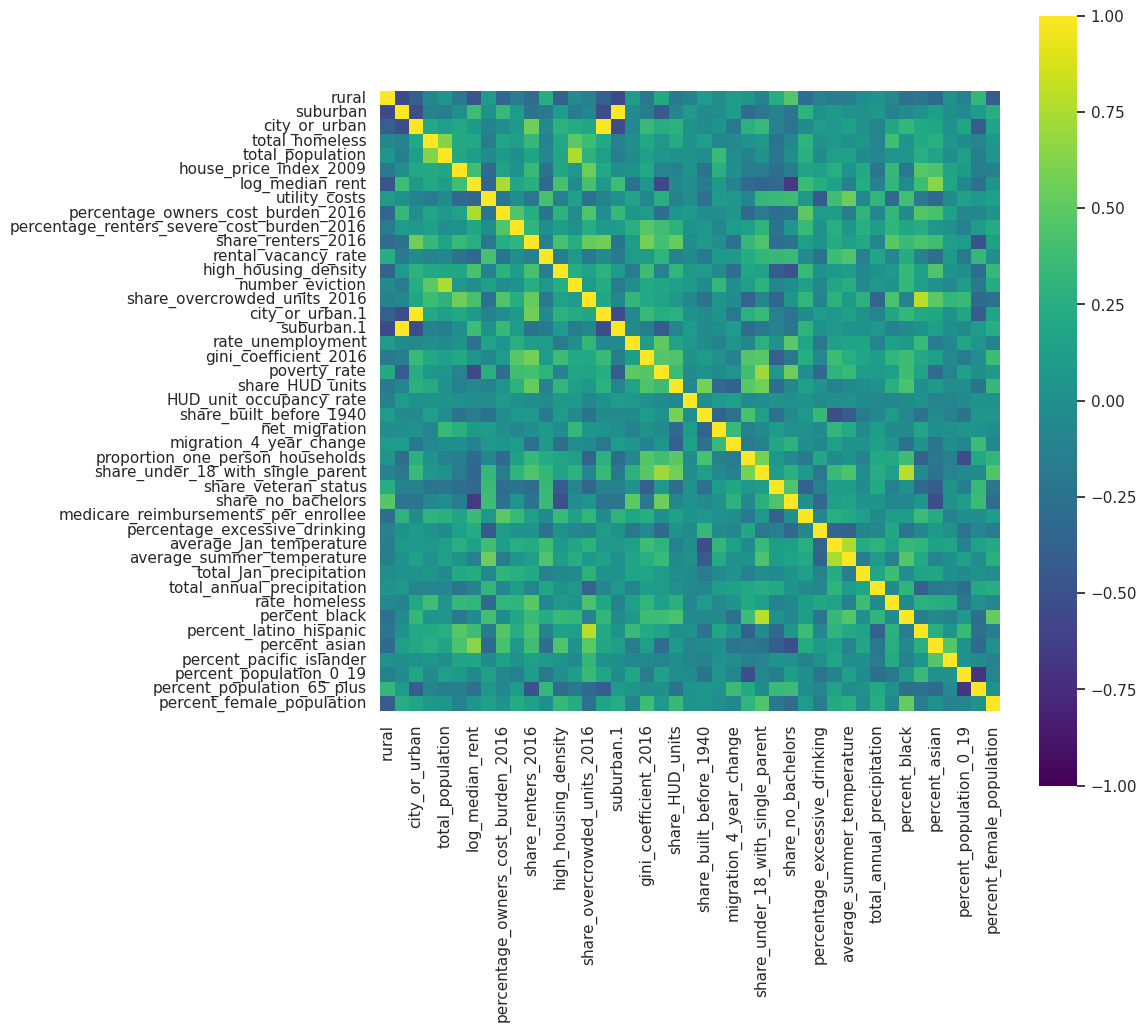

In [70]:
corr_matrix = df.drop(columns = ['coc_number']).corr()

plt.figure(figsize = (10,10))

sns.heatmap(corr_matrix, vmax = 1, vmin = -1, square = True, cmap = 'viridis')

#Fit Models on Full Dataset

In [71]:
scaler = RobustScaler().fit(X)

In [72]:
X = pd.DataFrame(data = scaler.transform(X), columns  = X.columns.values, index = X.index)

In [73]:
model = sm.OLS(Y, sm.add_constant(X)).fit()

In [74]:
X.shape

(374, 40)

In [75]:
y_prediction = model.predict(sm.add_constant(X))

In [76]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          rate_homeless   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     12.44
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           1.18e-43
Time:                        18:12:00   Log-Likelihood:                 6356.2
No. Observations:                 374   AIC:                        -1.264e+04
Df Residuals:                     336   BIC:                        -1.249e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

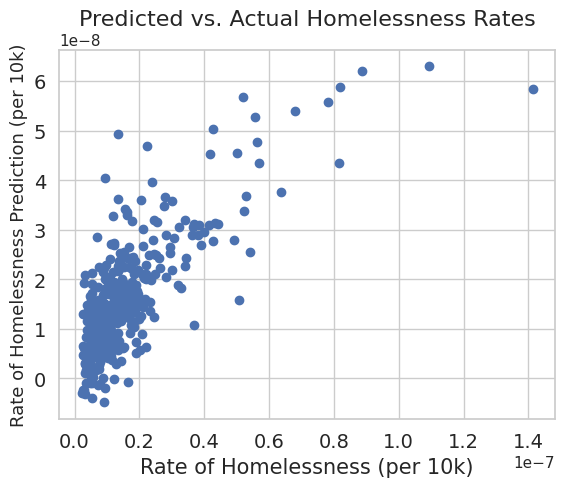

In [77]:
plt.plot(df['rate_homeless'], y_prediction, 'o')

# Add axis labels
plt.xlabel('Rate of Homelessness (per 10k)', fontsize=15)
plt.ylabel('Rate of Homelessness Prediction (per 10k)', fontsize=13)
plt.title('Predicted vs. Actual Homelessness Rates', fontsize = 16)

# Increase the fontsize of the tick labels 
plt.tick_params(labelsize=14);

This model uses too many variables to gather a clear idea of the relationship.

In [78]:
y_pred_lr = model.predict(sm.add_constant(X))

I think I have an issue with my data, as I am getting a lot of zeros, and Lasso is not running as it should. I checked it a lot in the data prep, so I think it's something in this notebook, but I'm not exactly sure what caused this. 

In [79]:
MSE = mean_squared_error(Y, y_pred_lr)
RMSE = np.sqrt(MSE)
R_squared = r2_score(Y, y_pred_lr)

print('MSE = ', MSE.round(3), 'RMSE = ', RMSE.round(3), 'R-squared = ', R_squared.round(3))

MSE =  0.0 RMSE =  0.0 R-squared =  0.578


In [80]:
mean_absolute_error(Y, y_pred_lr)

6.730766949751335e-09

## Fit Model on Training Dataset

In [81]:
scaler = RobustScaler().fit(x_train)

In [82]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Lasso

In [112]:
alphas = 10**np.linspace(-4,0,10)

In [113]:
print(alphas)

[1.00000000e-04 2.78255940e-04 7.74263683e-04 2.15443469e-03
 5.99484250e-03 1.66810054e-02 4.64158883e-02 1.29154967e-01
 3.59381366e-01 1.00000000e+00]


In [114]:
lasso = Lasso(max_iter = 100000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

ValueError: ignored

In [ ]:
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100_000)

In [ ]:
lassocv.fit(x_train, y_train)
lassocv.alpha_

In [ ]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, ":")
plt.plot(
    lassocv.alphas_ ,
    lassocv.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lassocv.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight");

In [ ]:
lasso_reg = Lasso(alpha = lassocv.alpha_).fit(x_train, y_train)

In [ ]:
coefficients = lasso_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, lasso_reg.intercept_.round(4))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(data = coefficients.round(2), index = variables, columns = ['Estimated Coefficient'])

In [ ]:
MSE_lasso = mean_squared_error(y_test, lasso_reg.predict(x_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_test, lasso_reg.predict(x_test))

print('MSE =', MSE_lasso.round(3), ' RMSE =', RMSE_lasso.round(3), ' R-squared =', R_squared_lasso.round(3))

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(y_test, lasso_reg.predict(x_test),'o', alpha = 0.4)

plt.xlabel('Log homeless rate',fontsize = 20)
plt.ylabel('Predicted log homeless rate',fontsize = 20)
plt.title('Lasso' + ' ' + ' RMSE = ' + str(RMSE_lasso.round(2)),fontsize = 14);

## Ridge

In [93]:
alphas = 10**np.linspace(-3,5,20)

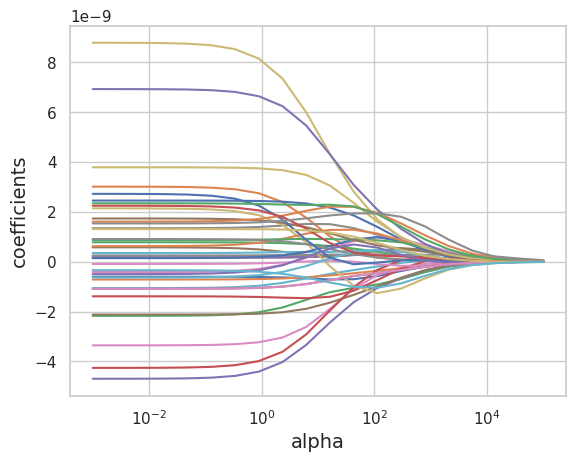

In [94]:
ridge = Ridge(max_iter = 100000)
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(x_train, y_train)
    coefs.append(ridge.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

In [95]:
ridgecv = RidgeCV(alphas = alphas, cv = 5, scoring = 'neg_mean_squared_error')

ridgecv.fit(x_train, y_train);

In [96]:
ridgecv.alpha_

112.88378916846884

In [97]:
ridge_reg = Ridge(alpha = ridgecv.alpha_).fit(x_train, y_train)

In [98]:
coefficients = ridge_reg.coef_.round(3)
coefficients = np.insert(coefficients, 0, ridge_reg.intercept_.round(3))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(data = coefficients, index = variables, columns = ['Estimated Coefficient'])

,Estimated Coefficient
intercept,0.0
HUD_unit_occupancy_rate,-0.0
average_Jan_temperature,0.0
average_summer_temperature,-0.0
city_or_urban,0.0
city_or_urban.1,0.0
gini_coefficient_2016,0.0
high_housing_density,-0.0
house_price_index_2009,0.0
log_median_rent,0.0


In [99]:
MSE_ridge = mean_squared_error(y_test, ridge_reg.predict(x_test))
RMSE_ridge = np.sqrt(MSE_ridge)
R_squared_ridge = r2_score(y_test, ridge_reg.predict(x_test))

print('MSE =', MSE_ridge.round(3), ' RMSE =', RMSE_ridge.round(3), ' R-squared =', R_squared_ridge.round(3))

MSE = 0.0  RMSE = 0.0  R-squared = 0.541


In [100]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True, scoring = 'neg_mean_squared_error')

search.fit(x_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f38ecbb1930>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f38ecbb0b80>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f38ecbb2770>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f38ecbb1090>},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

## XGBoost Model

In [101]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True, scoring = 'neg_mean_squared_error')

search.fit(x_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f38ecbb13c0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f38ecbb2170>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f38ecc2f7c0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f38ecbb2ef0>},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [102]:
search.best_params_

{'colsample_bytree': 0.8939277096449881,
 'gamma': 0.2269967604244349,
 'learning_rate': 0.30050776943888224,
 'max_depth': 2,
 'n_estimators': 120,
 'subsample': 0.6722906130860137}

In [103]:
model_xgb = xgb.XGBRegressor(objective="reg:squarederror")
model_xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [104]:
model_xgb.set_params(**search.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8939277096449881, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2269967604244349, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.30050776943888224, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=120, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [105]:
y_pred_xgb = model_xgb.predict(x_test)

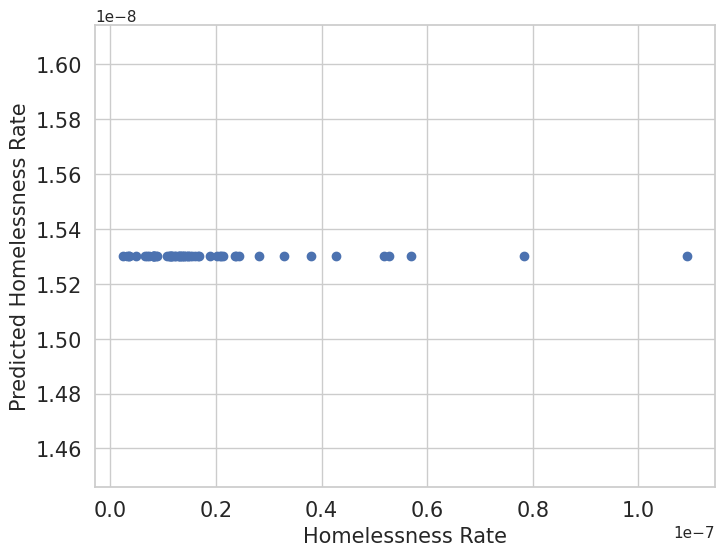

In [106]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_pred_xgb, 'o');

plt.xlabel('Homelessness Rate', fontsize = 15)
plt.ylabel('Predicted Homelessness Rate', fontsize = 15)

plt.tick_params(labelsize = 15)

In [107]:
mean_squared_error(y_test, y_pred_xgb, squared = False).round(3)

0.0

In [111]:
(pd.DataFrame(dict(cols=X.columns, imp=model_xgb.feature_importances_)).
 sort_values(by = 'imp').
 plot('cols', 'imp', 'barh', legend = False, figsize = (4,5)))

plt.ylabel('')
plt.xlabel('Variable importance', fontsize = 15)

plt.tick_params(labelsize = 15);

ValueError: ignored

# Additional Step - Density

## Conclusion

Provide a brief description of your conclusions.